In [59]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost.callback import EarlyStopping
from mlxtend.classifier import StackingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [26]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [30]:
print(xgb.__version__)

2.1.4


In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('ggplot')

In [3]:
# Load breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# For some visual examples, we'll also create a simple 2D dataset
X_2d, y_2d = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y_2d, test_size=0.2, random_state=42)

In [5]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_2d_scaled = scaler.fit_transform(X_train_2d)
X_test_2d_scaled = scaler.transform(X_test_2d)

In [6]:
# Print dataset information
print(f"Breast Cancer Dataset Shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

Breast Cancer Dataset Shape: (569, 30)
Number of classes: 2
Class distribution: [212 357]


In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """Evaluate a model and print performance metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=data.target_names,
                yticklabels=data.target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        # ROC Curve
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.show()

    return accuracy

In [8]:
def plot_decision_boundary(model, X, y, model_name="Model"):
    """Plot decision boundary for 2D data."""
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict class labels for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=50, cmap=plt.cm.coolwarm)
    plt.title(f'Decision Boundary - {model_name}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

In [9]:
def compare_models(models, X_train, X_test, y_train, y_test):
    """Compare multiple models and visualize their performance."""
    accuracies = {}
    cv_scores = {}

    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies[name] = accuracy_score(y_test, y_pred)

        # 5-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        cv_scores[name] = scores.mean()

        print(f"Test Accuracy: {accuracies[name]:.4f}")
        print(f"CV Accuracy: {cv_scores[name]:.4f}")

    # Bar chart of accuracies
    plt.figure(figsize=(12, 6))
    models_list = list(accuracies.keys())
    acc_list = [accuracies[model] for model in models_list]
    cv_list = [cv_scores[model] for model in models_list]

    x = np.arange(len(models_list))
    width = 0.35

    plt.bar(x - width/2, acc_list, width, label='Test Accuracy')
    plt.bar(x + width/2, cv_list, width, label='Cross-Validation Accuracy')

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models_list, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return accuracies, cv_scores

In [10]:
def feature_importance_plot(model, feature_names, model_name="Model"):
    """Plot feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-20:]  # Top 20 features

        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance - {model_name}')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(f"The {model_name} doesn't provide feature importances directly.")

# 1. Voting Ensemble

In [11]:
def implement_voting_classifier():
    """Implement and evaluate a voting classifier."""
    # Create base models
    log_clf = LogisticRegression(random_state=42, max_iter=1000)
    svm_clf = SVC(random_state=42, probability=True)
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    dt_clf = DecisionTreeClassifier(random_state=42)

    # Create hard voting classifier
    hard_voting_clf = VotingClassifier(
        estimators=[
            ('logistic', log_clf),
            ('svc', svm_clf),
            ('knn', knn_clf),
            ('dt', dt_clf)
        ],
        voting='hard'
    )

    # Create soft voting classifier
    soft_voting_clf = VotingClassifier(
        estimators=[
            ('logistic', log_clf),
            ('svc', svm_clf),
            ('knn', knn_clf),
            ('dt', dt_clf)
        ],
        voting='soft'
    )

    # Evaluate individual models and voting ensembles
    models = {
        'Logistic Regression': log_clf,
        'SVM': svm_clf,
        'KNN': knn_clf,
        'Decision Tree': dt_clf,
        'Hard Voting': hard_voting_clf,
        'Soft Voting': soft_voting_clf
    }

    accuracies, cv_scores = compare_models(models, X_train_scaled, X_test_scaled, y_train, y_test)

    # Visualize decision boundaries on 2D data
    plt.figure(figsize=(20, 15))
    plt.suptitle("Decision Boundaries for Individual Models and Voting Ensembles", fontsize=16)

    # Fit models on 2D data for visualization
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train_2d_scaled, y_train_2d)
        plt.subplot(2, 3, i+1)

        # Create mesh grid
        h = 0.02
        x_min, x_max = X_train_2d_scaled[:, 0].min() - 1, X_train_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_train_2d_scaled[:, 1].min() - 1, X_train_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Predict and plot
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

        # Plot training points
        plt.scatter(X_train_2d_scaled[:, 0], X_train_2d_scaled[:, 1], c=y_train_2d,
                   edgecolor='k', s=20, cmap=plt.cm.coolwarm)
        plt.title(name)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return hard_voting_clf, soft_voting_clf


Evaluating Logistic Regression...
Test Accuracy: 0.9737
CV Accuracy: 0.9780

Evaluating SVM...
Test Accuracy: 0.9825
CV Accuracy: 0.9736

Evaluating KNN...
Test Accuracy: 0.9474
CV Accuracy: 0.9626

Evaluating Decision Tree...
Test Accuracy: 0.9474
CV Accuracy: 0.8857

Evaluating Hard Voting...
Test Accuracy: 0.9737
CV Accuracy: 0.9780

Evaluating Soft Voting...
Test Accuracy: 0.9737
CV Accuracy: 0.9736


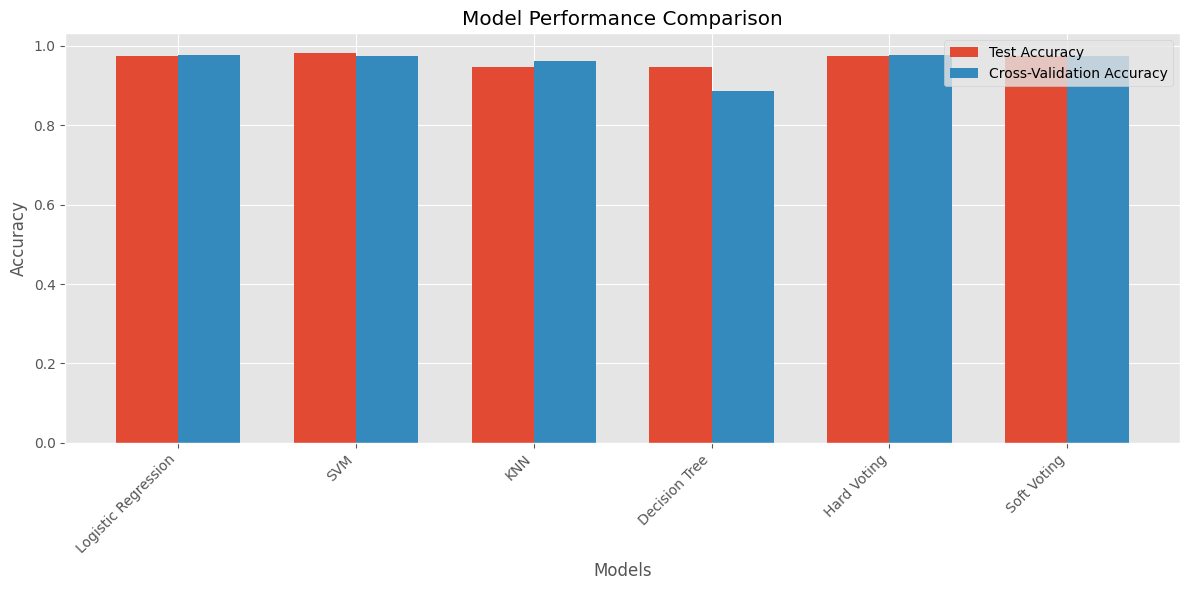

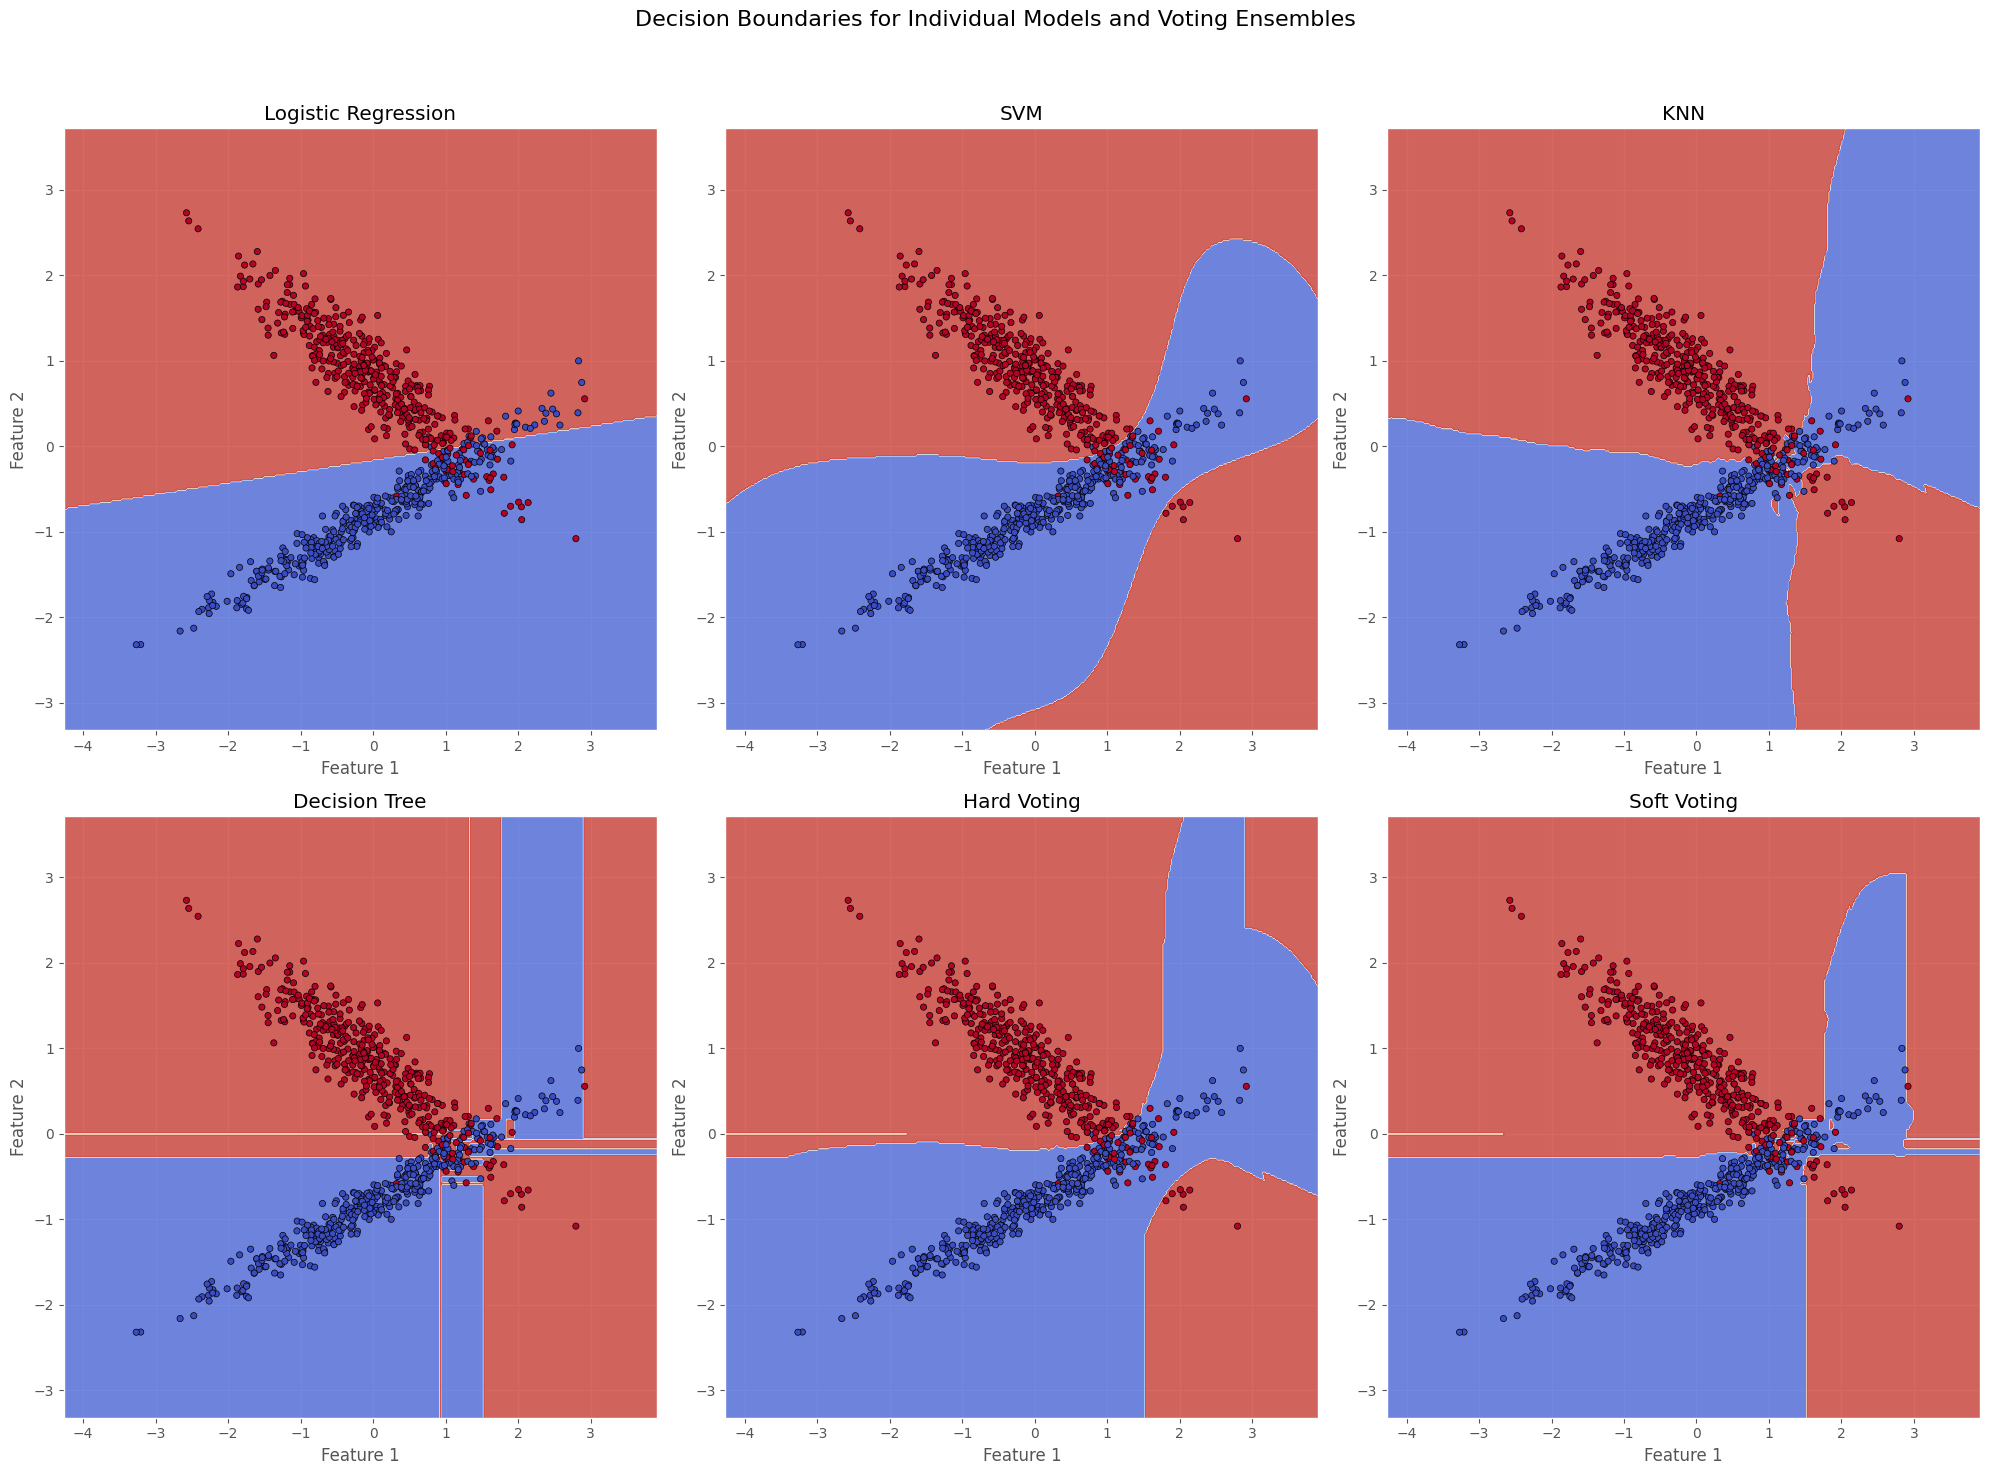

In [12]:
# Run voting classifier implementation
hard_voting_clf, soft_voting_clf = implement_voting_classifier()

# 2. Bagging - Random Forest

In [13]:
def implement_random_forest():
    """Implement and evaluate a Random Forest classifier."""
    # Create and train a Random Forest model
    rf_clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    )

    # Evaluate the model
    accuracy = evaluate_model(rf_clf, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

    # Feature importance plot
    feature_importance_plot(rf_clf, data.feature_names, "Random Forest")

    # Visualize decision trees in the forest
    plt.figure(figsize=(15, 10))

    # Plot first 5 trees' decision boundaries
    for i in range(min(5, len(rf_clf.estimators_))):
        tree = rf_clf.estimators_[i]
        plt.subplot(2, 3, i+1)

        # Create mesh grid
        h = 0.02
        x_min, x_max = X_train_2d_scaled[:, 0].min() - 1, X_train_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_train_2d_scaled[:, 1].min() - 1, X_train_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Fit the tree on 2D data for visualization
        tree.fit(X_train_2d_scaled, y_train_2d)

        # Predict and plot
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

        # Plot training points
        plt.scatter(X_train_2d_scaled[:, 0], X_train_2d_scaled[:, 1], c=y_train_2d,
                   edgecolor='k', s=20, cmap=plt.cm.coolwarm)
        plt.title(f"Tree {i+1}")
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    # Plot the ensemble decision boundary
    rf_2d = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_2d.fit(X_train_2d_scaled, y_train_2d)
    plt.subplot(2, 3, 6)

    Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X_train_2d_scaled[:, 0], X_train_2d_scaled[:, 1], c=y_train_2d,
               edgecolor='k', s=20, cmap=plt.cm.coolwarm)
    plt.title("Random Forest (Ensemble)")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

    # Visualize how performance varies with the number of trees
    n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
    train_accuracy = []
    test_accuracy = []

    for n_estimators in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf.fit(X_train_scaled, y_train)
        train_accuracy.append(accuracy_score(y_train, rf.predict(X_train_scaled)))
        test_accuracy.append(accuracy_score(y_test, rf.predict(X_test_scaled)))

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(n_estimators_range, test_accuracy, label='Testing Accuracy', marker='s')
    plt.xscale('log')
    plt.xlabel('Number of Trees (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Random Forest Performance vs Number of Trees')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rf_clf

Random Forest Performance:
Accuracy: 0.9649

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



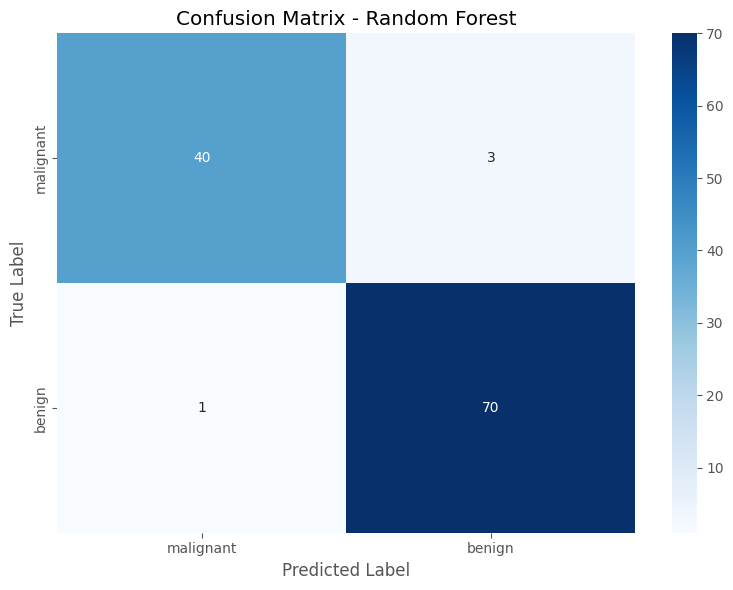

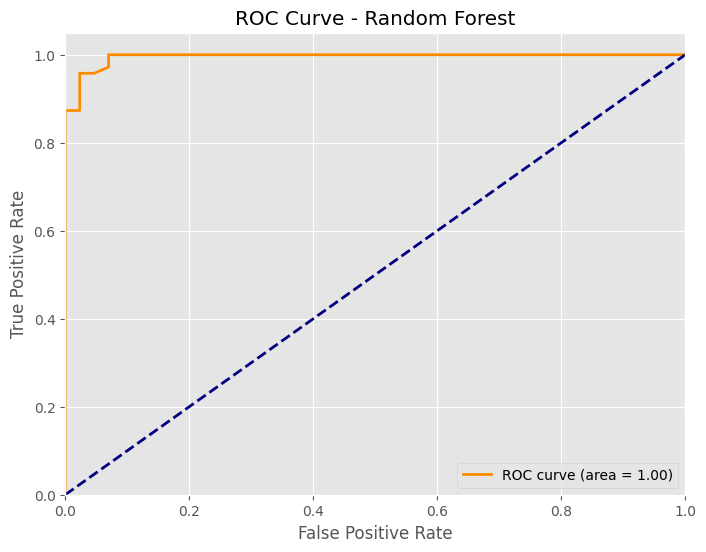

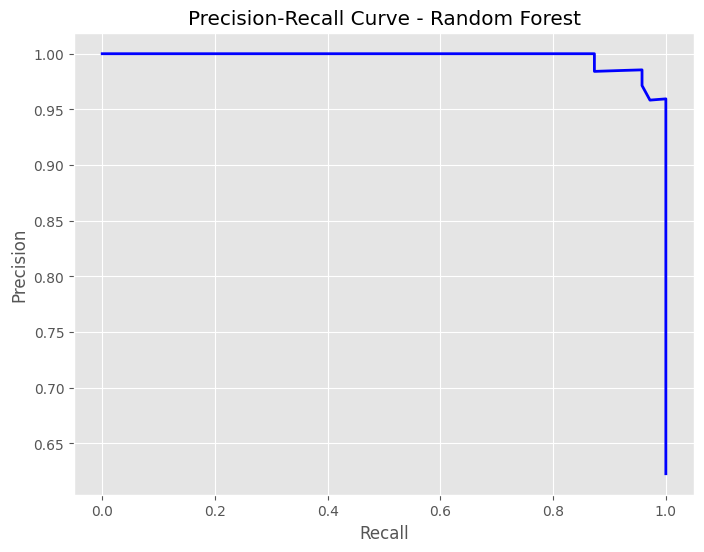

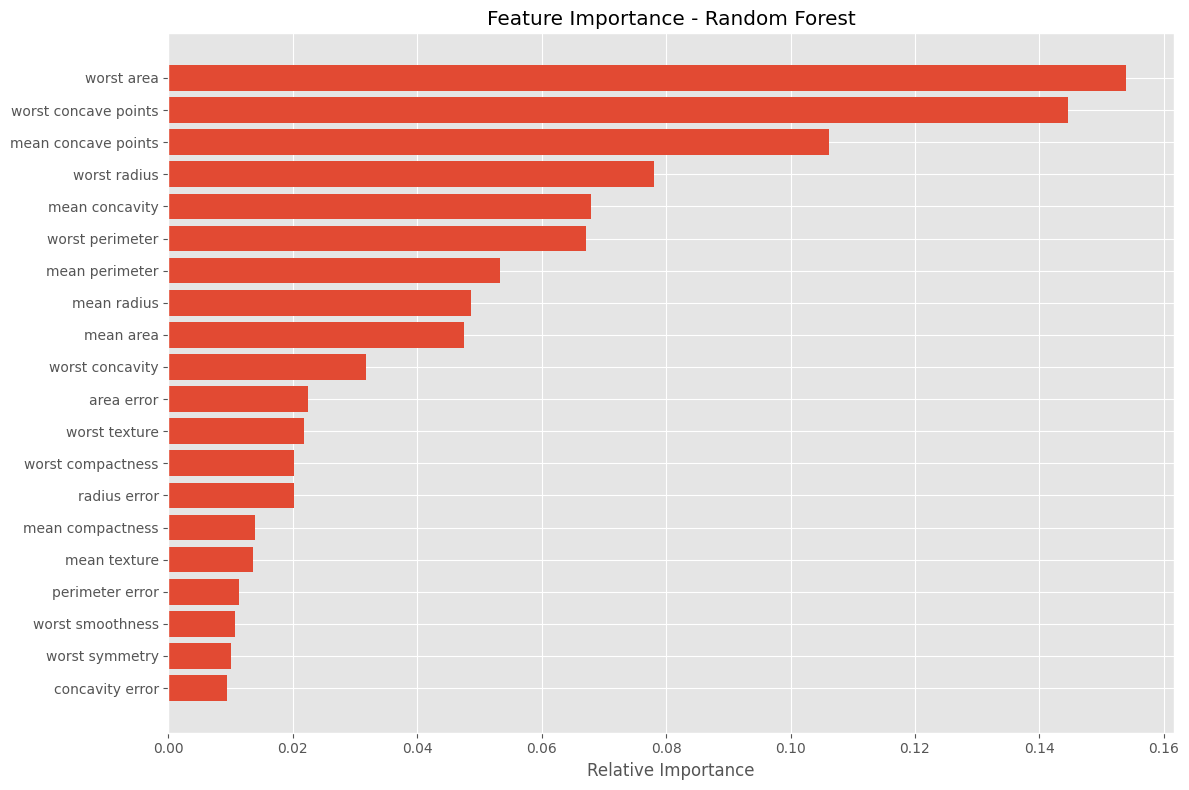

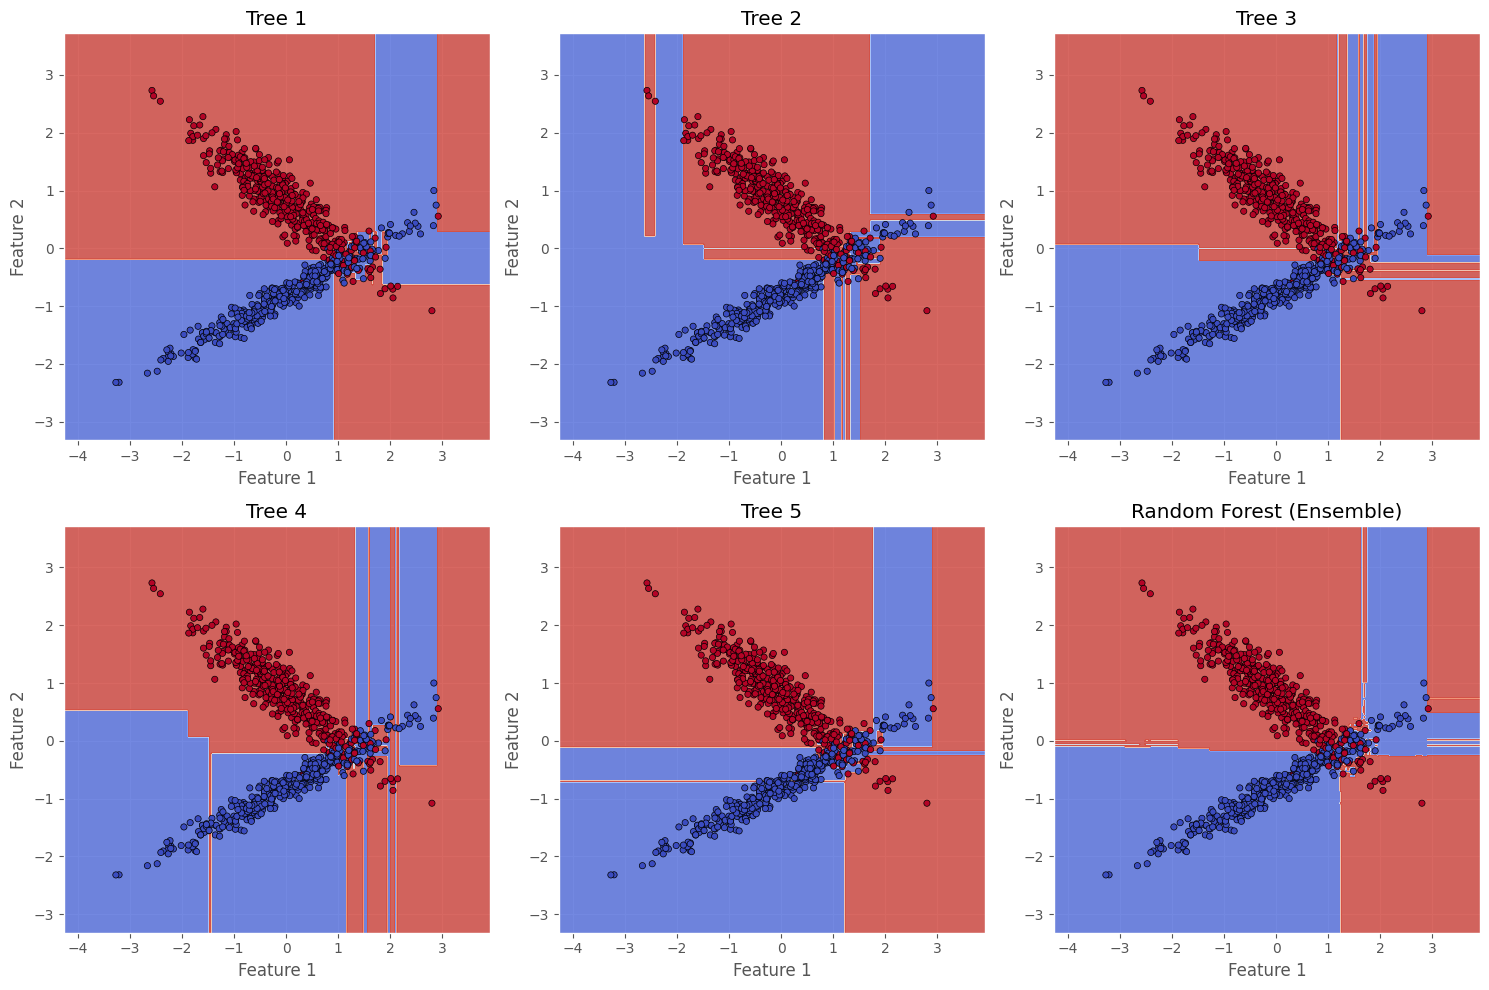

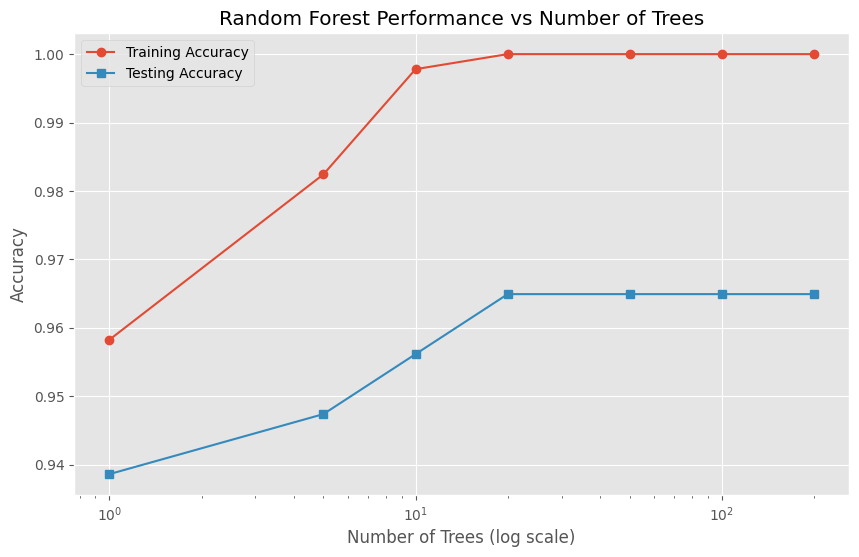

In [14]:
# Run Random Forest implementation
rf_clf = implement_random_forest()

# 3. Boosting

## 3A. Boosting - AdaBoost

In [19]:
def implement_adaboost():
    """Implement and evaluate an AdaBoost classifier."""
    # Create and train an AdaBoost model
    # Using default parameters that work across scikit-learn versions
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),  # Using decision stumps as first positional argument
        n_estimators=100,
        algorithm="SAMME",  # Changed from SAMME.R to SAMME
        random_state=42
    )

    # Evaluate the model
    accuracy = evaluate_model(ada_clf, X_train_scaled, X_test_scaled, y_train, y_test, "AdaBoost")

    # Feature importance plot
    feature_importance_plot(ada_clf, data.feature_names, "AdaBoost")

    # Visualize how performance varies with the number of estimators
    n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
    train_accuracy = []
    test_accuracy = []

    for n_estimators in n_estimators_range:
        ada = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=n_estimators,
            algorithm="SAMME",  # Changed from SAMME.R to SAMME
            random_state=42
        )
        ada.fit(X_train_scaled, y_train)
        train_accuracy.append(accuracy_score(y_train, ada.predict(X_train_scaled)))
        test_accuracy.append(accuracy_score(y_test, ada.predict(X_test_scaled)))

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(n_estimators_range, test_accuracy, label='Testing Accuracy', marker='s')
    plt.xscale('log')
    plt.xlabel('Number of Estimators (log scale)')
    plt.ylabel('Accuracy')
    plt.title('AdaBoost Performance vs Number of Estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize decision boundary evolution
    plt.figure(figsize=(15, 8))
    plt.suptitle("AdaBoost Decision Boundary Evolution", fontsize=16)

    estimator_numbers = [1, 5, 10, 50, 100]
    for i, n_estimators in enumerate(estimator_numbers):
        # Create and train AdaBoost on 2D data
        ada_2d = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=n_estimators,
            algorithm="SAMME",  # Changed from SAMME.R to SAMME
            random_state=42
        )
        ada_2d.fit(X_train_2d_scaled, y_train_2d)

        # Plot decision boundary
        plt.subplot(1, len(estimator_numbers), i+1)

        # Create mesh grid
        h = 0.02
        x_min, x_max = X_train_2d_scaled[:, 0].min() - 1, X_train_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_train_2d_scaled[:, 1].min() - 1, X_train_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Predict and plot
        Z = ada_2d.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

        # Plot training points
        plt.scatter(X_train_2d_scaled[:, 0], X_train_2d_scaled[:, 1], c=y_train_2d,
                   edgecolor='k', s=20, cmap=plt.cm.coolwarm)
        plt.title(f"n_estimators = {n_estimators}")
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return ada_clf

AdaBoost Performance:
Accuracy: 0.9737

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



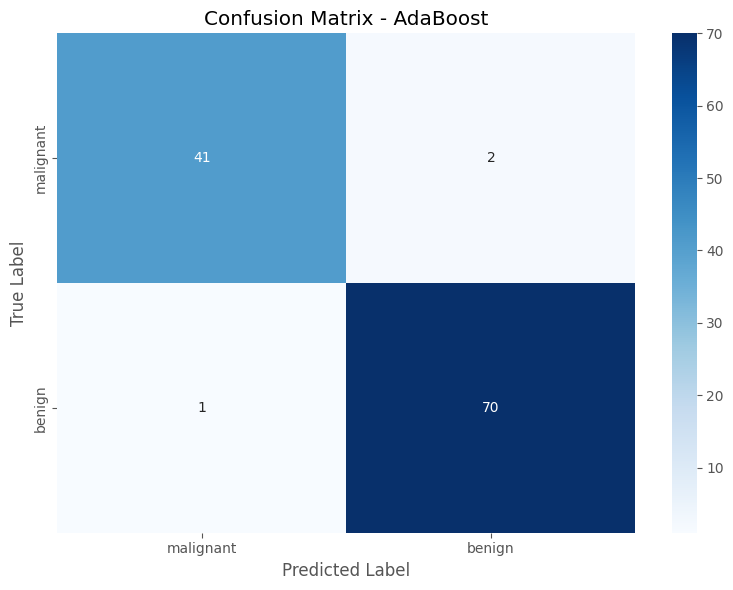

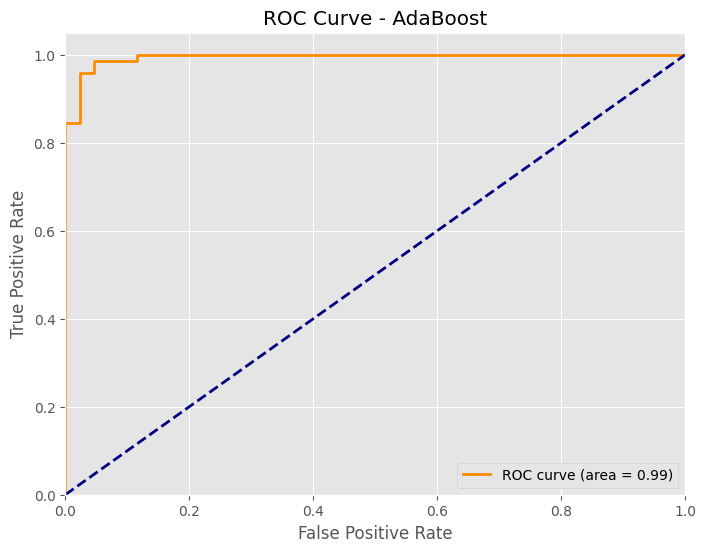

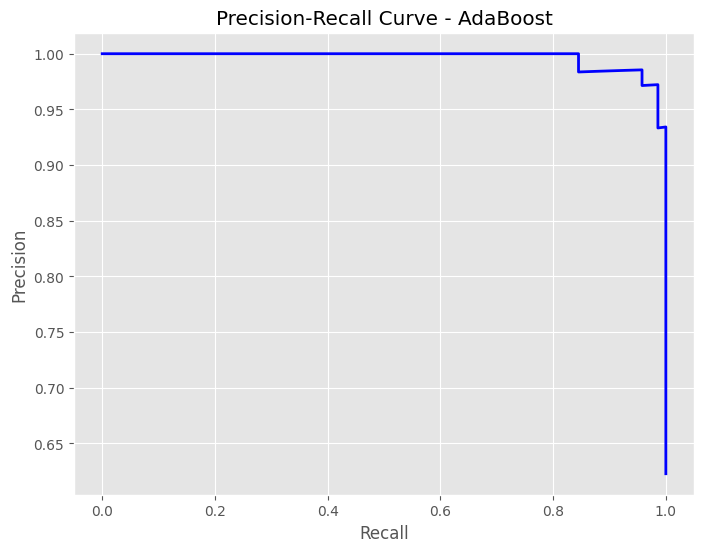

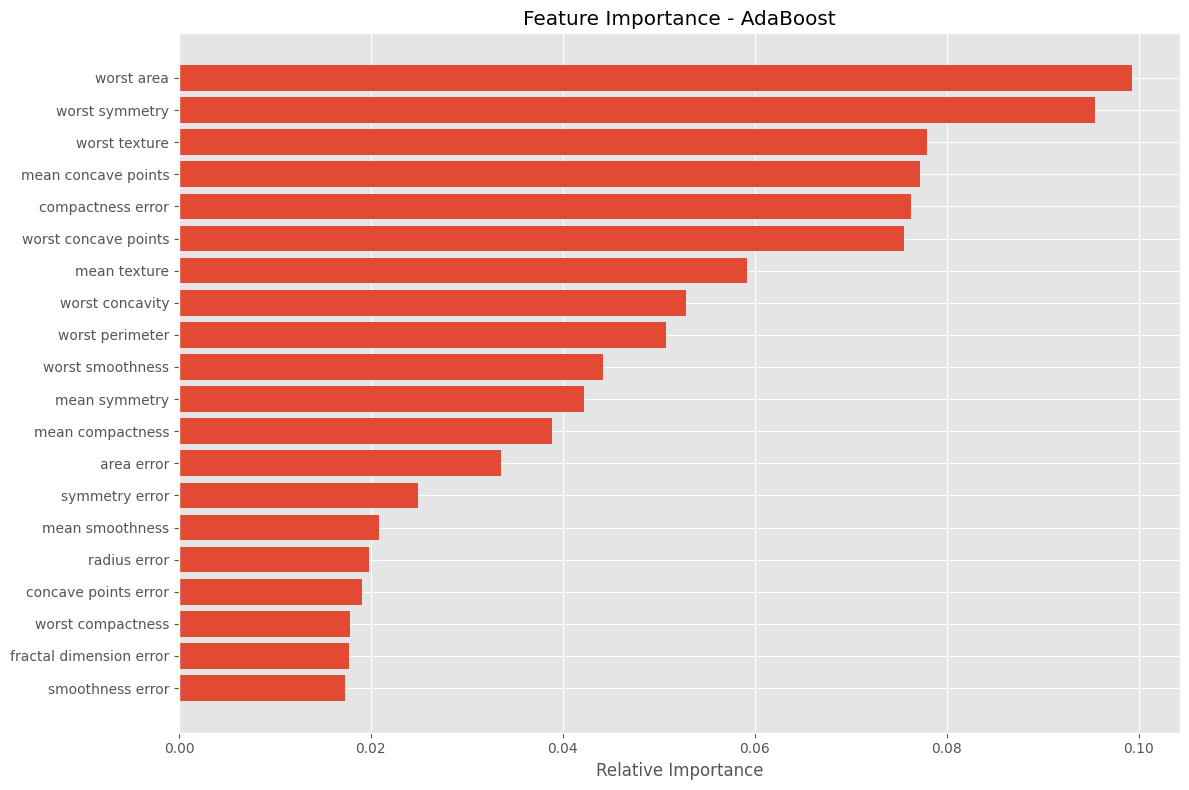

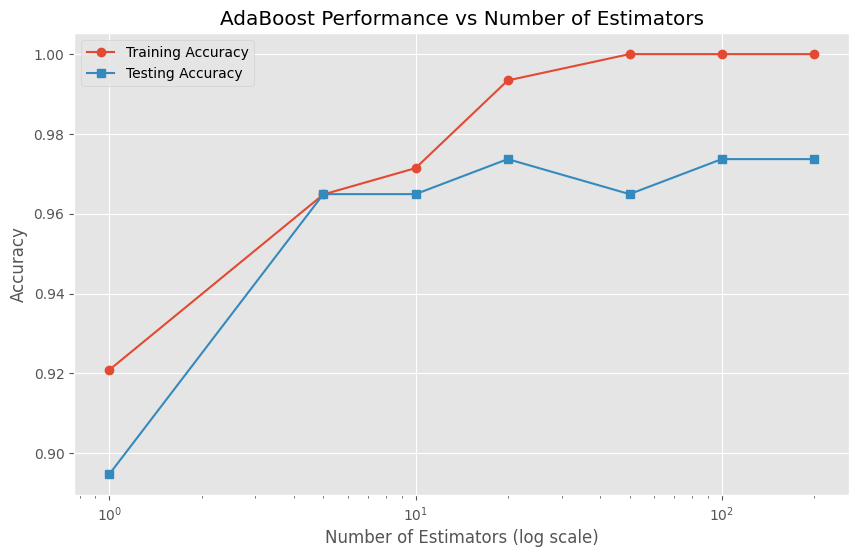

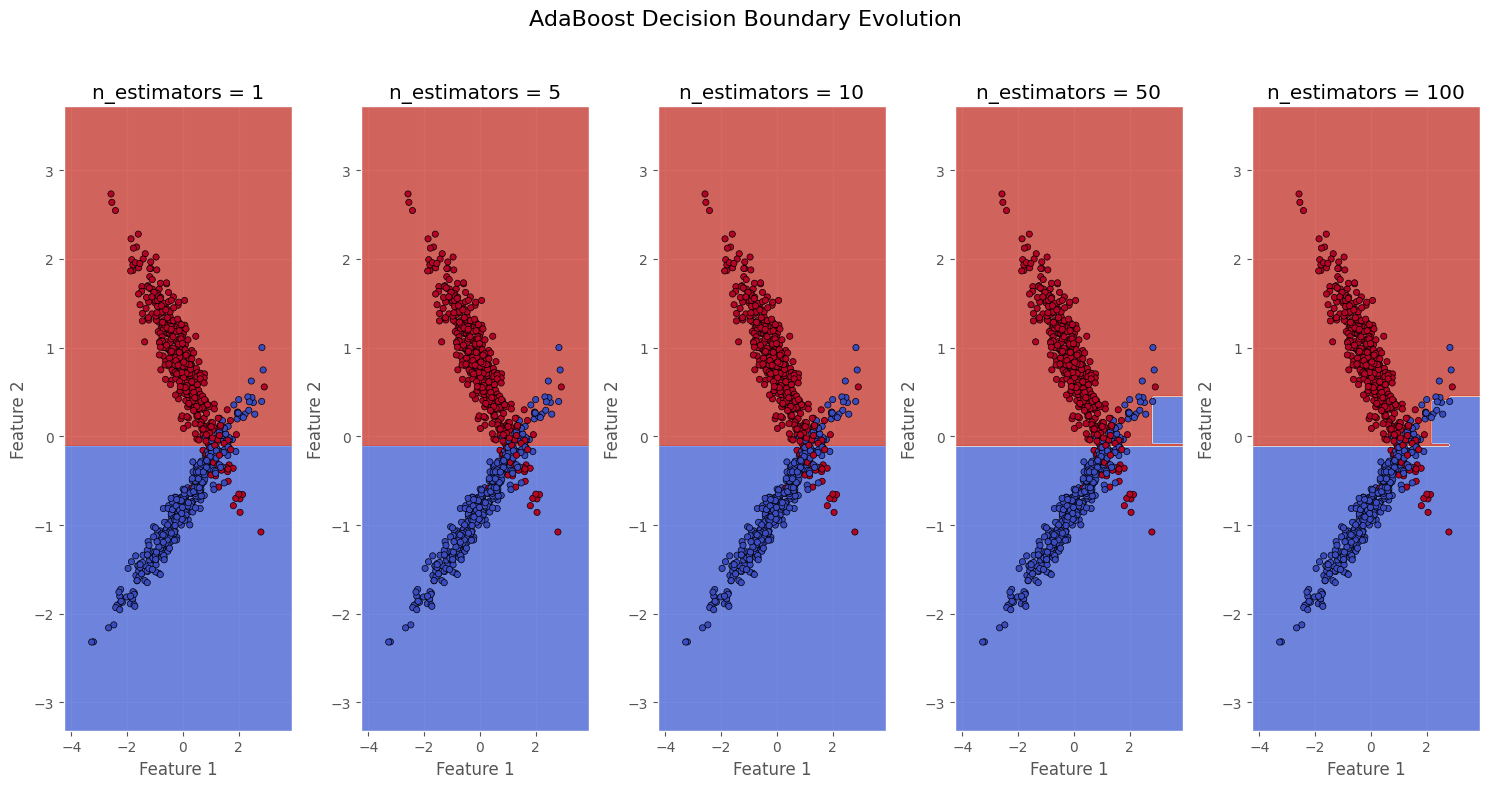

In [20]:
# Run AdaBoost implementation
ada_clf = implement_adaboost()

## 3B. Boosting - Gradient Boosting

In [21]:
def implement_gradient_boosting():
    """Implement and evaluate a Gradient Boosting classifier."""
    # Create and train a Gradient Boosting model
    gb_clf = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

    # Evaluate the model
    accuracy = evaluate_model(gb_clf, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")

    # Feature importance plot
    feature_importance_plot(gb_clf, data.feature_names, "Gradient Boosting")

    # Learning curves: how loss and test error evolve with more trees
    gb_clf.fit(X_train_scaled, y_train)

    # Accessing staged predictions to see how error evolves
    staged_train_scores = []
    staged_test_scores = []

    for y_train_pred in gb_clf.staged_predict(X_train_scaled):
        staged_train_scores.append(accuracy_score(y_train, y_train_pred))

    for y_test_pred in gb_clf.staged_predict(X_test_scaled):
        staged_test_scores.append(accuracy_score(y_test, y_test_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, gb_clf.n_estimators + 1), staged_train_scores, label='Training Accuracy')
    plt.plot(range(1, gb_clf.n_estimators + 1), staged_test_scores, label='Testing Accuracy')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.title('Gradient Boosting Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize how learning rate affects performance
    learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
    train_accuracy = []
    test_accuracy = []

    for lr in learning_rates:
        gb = GradientBoostingClassifier(n_estimators=100, learning_rate=lr, max_depth=3, random_state=42)
        gb.fit(X_train_scaled, y_train)
        train_accuracy.append(accuracy_score(y_train, gb.predict(X_train_scaled)))
        test_accuracy.append(accuracy_score(y_test, gb.predict(X_test_scaled)))

    plt.figure(figsize=(10, 6))
    plt.semilogx(learning_rates, train_accuracy, label='Training Accuracy', marker='o')
    plt.semilogx(learning_rates, test_accuracy, label='Testing Accuracy', marker='s')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Accuracy')
    plt.title('Gradient Boosting Performance vs Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize decision boundary evolution with different numbers of estimators
    plt.figure(figsize=(15, 8))
    plt.suptitle("Gradient Boosting Decision Boundary Evolution", fontsize=16)

    estimator_numbers = [1, 5, 10, 50, 100]
    for i, n_estimators in enumerate(estimator_numbers):
        # Create and train Gradient Boosting on 2D data
        gb_2d = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
        gb_2d.fit(X_train_2d_scaled, y_train_2d)

        # Plot decision boundary
        plt.subplot(1, len(estimator_numbers), i+1)

        # Create mesh grid
        h = 0.02
        x_min, x_max = X_train_2d_scaled[:, 0].min() - 1, X_train_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_train_2d_scaled[:, 1].min() - 1, X_train_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Predict and plot
        Z = gb_2d.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

        # Plot training points
        plt.scatter(X_train_2d_scaled[:, 0], X_train_2d_scaled[:, 1], c=y_train_2d,
                   edgecolor='k', s=20, cmap=plt.cm.coolwarm)
        plt.title(f"n_estimators = {n_estimators}")
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return gb_clf

Gradient Boosting Performance:
Accuracy: 0.9561

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



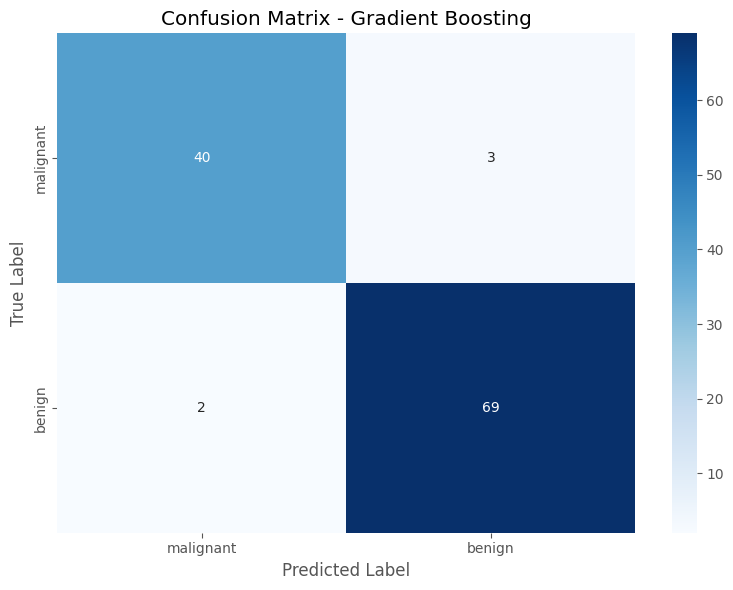

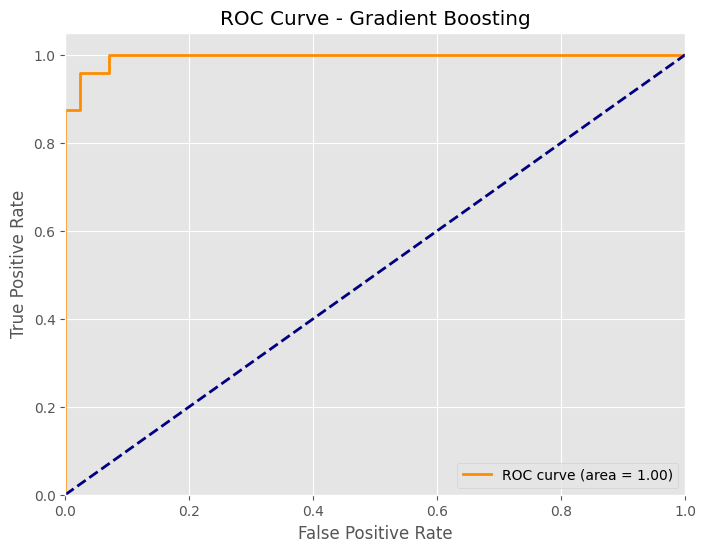

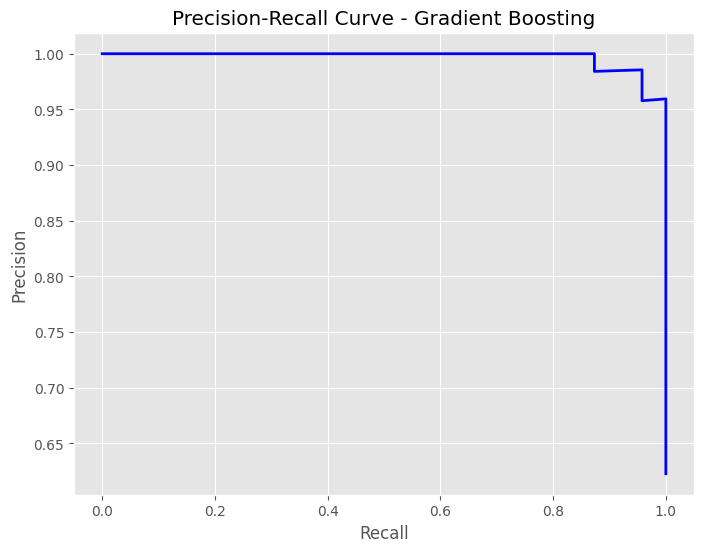

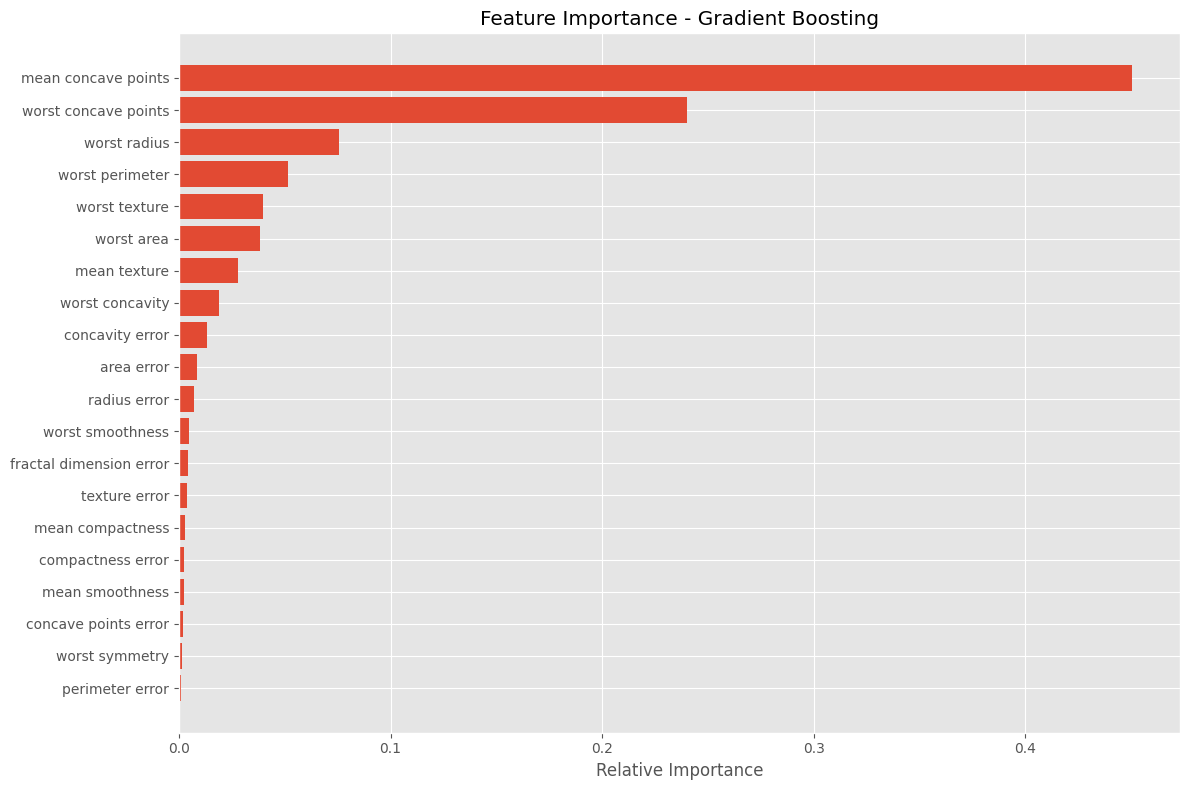

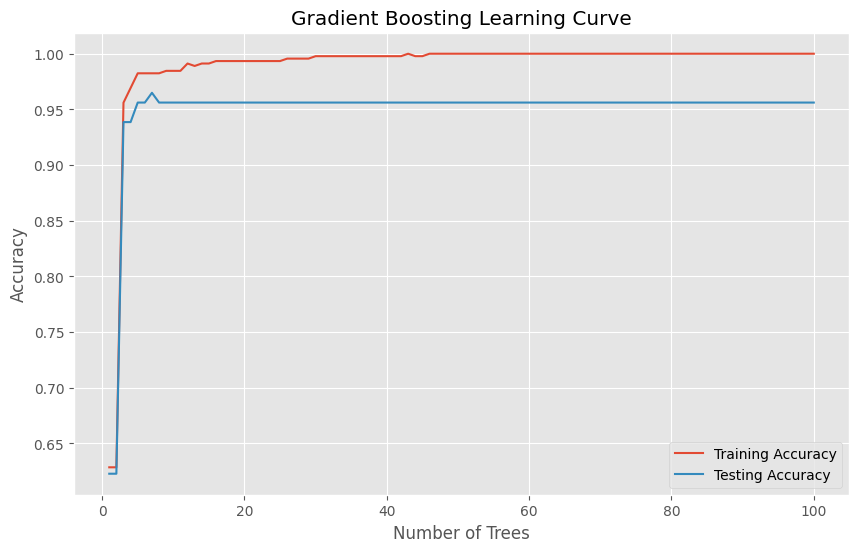

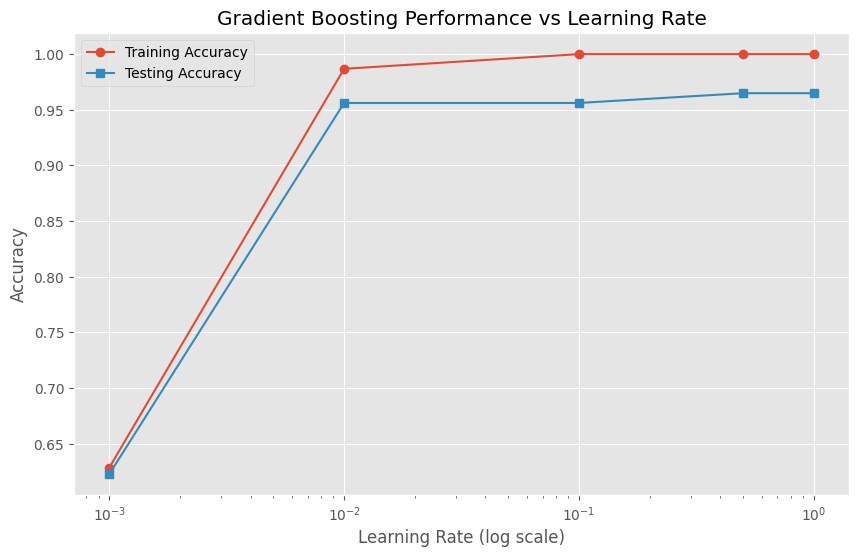

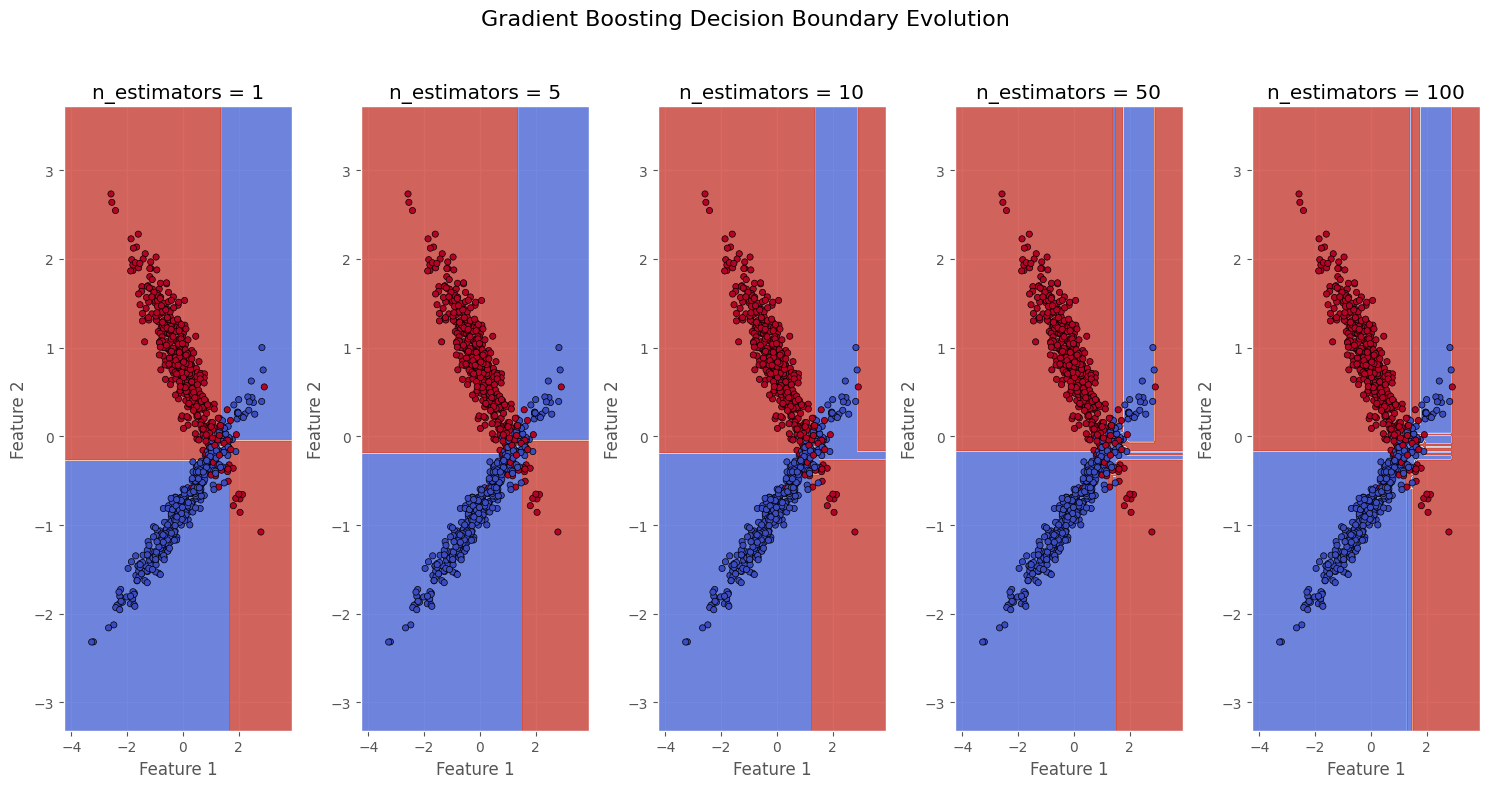

In [22]:
# Run Gradient Boosting implementation
gb_clf = implement_gradient_boosting()

## 3C. Boosting - XGBoost

In [54]:
def implement_xgboost():
    """Implement and evaluate an XGBoost classifier."""

    # Create and train an XGBoost model
    xgb_clf = xgb.XGBClassifier(
        n_estimators=1000,  # Use a high number of boosting rounds
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # Split the data for early stopping
    X_train_es, X_val, y_train_es, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, random_state=42
    )

    # Train with early stopping
    xgb_clf.fit(
        X_train_es, y_train_es,
        eval_set=[(X_train_es, y_train_es), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=True
    )

    # Get the best iteration (where early stopping occurred)
    best_iteration = xgb_clf.best_iteration
    print(f"Best iteration: {best_iteration}")

    # Make predictions using the best iteration
    y_pred = xgb_clf.predict(X_test_scaled)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Plot feature importance
    xgb.plot_importance(xgb_clf, importance_type='weight', max_num_features=10)
    plt.show()

    # Visualize the learning curve (logloss vs num_boost_round)
    evals_result = xgb_clf.evals_result()
    train_logloss = evals_result['validation_0']['logloss']
    val_logloss = evals_result['validation_1']['logloss']

    plt.plot(range(len(train_logloss)), train_logloss, label='Train LogLoss')
    plt.plot(range(len(val_logloss)), val_logloss, label='Validation LogLoss')
    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel('LogLoss')
    plt.title('XGBoost LogLoss vs Number of Trees')
    plt.legend()
    plt.grid(True)
    plt.show()

    return xgb_clf

In [55]:
# Run XGBoost implementation
xgb_clf = implement_xgboost()

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

# 4. Stacking

In [56]:
def implement_stacking():
    """Implement and evaluate a stacking classifier."""
    # Define base models
    base_models = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ]

    # Define meta-model
    meta_model = LogisticRegression(random_state=42)

    # Create stacking classifier
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        stack_method='auto'
    )

    # Evaluate the model
    accuracy = evaluate_model(stacking_clf, X_train_scaled, X_test_scaled, y_train, y_test, "Stacking")

    # Compare stacking with base models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Stacking': stacking_clf
    }

    accuracies, cv_scores = compare_models(models, X_train_scaled, X_test_scaled, y_train, y_test)

    # Visualize decision boundaries on 2D data
    plt.figure(figsize=(15, 10))
    plt.suptitle("Decision Boundaries for Base Models and Stacking Ensemble", fontsize=16)

    # Fit models on 2D data for visualization
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train_2d_scaled, y_train_2d)
        plt.subplot(2, 2, i+1)

        # Create mesh grid
        h = 0.02
        x_min, x_max = X_train_2d_scaled[:, 0].min() - 1, X_train_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_train_2d_scaled[:, 1].min() - 1, X_train_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Predict and plot
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

        # Plot training points
        plt.scatter(X_train_2d_scaled[:, 0], X_train_2d_scaled[:, 1], c=y_train_2d,
                   edgecolor='k', s=20, cmap=plt.cm.coolwarm)
        plt.title(name)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return stacking_clf

In [57]:
# Implement stacking
stacking_clf = implement_stacking()

TypeError: StackingClassifier.__init__() got an unexpected keyword argument 'estimators'

In [58]:
def compare_all_methods():
    """Compare all implemented ensemble methods."""
    # Define all models
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Hard Voting': hard_voting_clf,
        'Soft Voting': soft_voting_clf,
        'Random Forest': rf_clf,
        'AdaBoost': ada_clf,
        'Gradient Boosting': gb_clf,
        'XGBoost': xgb_clf,
        'Stacking': stacking_clf
    }

    # Compare models
    accuracies, cv_scores = compare_models(models, X_train_scaled, X_test_scaled, y_train, y_test)

    # Create radar chart for comprehensive comparison
    categories = list(accuracies.keys())
    N = len(categories)

    # Convert to list for plotting
    acc_values = [accuracies[model] for model in categories]
    cv_values = [cv_scores[model] for model in categories]

    # Create angles for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Add the values for the closed loop
    acc_values += acc_values[:1]
    cv_values += cv_values[:1]

    # Plot the radar chart
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))

    # Plot accuracy values
    ax.plot(angles, acc_values, 'o-', linewidth=2, label='Test Accuracy')
    ax.fill(angles, acc_values, alpha=0.25)

    # Plot CV values
    ax.plot(angles, cv_values, 'o-', linewidth=2, label='CV Accuracy')
    ax.fill(angles, cv_values, alpha=0.25)

    # Set category labels
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)

    # Set y-axis labels
    ax.set_yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1.0])
    ax.set_yticklabels(['0.90', '0.92', '0.94', '0.96', '0.98', '1.0'])

    # Add legend and title
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Comparison of Ensemble Methods', size=15, y=1.1)
    plt.tight_layout()
    plt.show()

    # Compute training time comparison
    training_times = {}

    for name, model in models.items():
        if name not in ['Hard Voting', 'Soft Voting', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'Stacking']:
            start_time = time.time()
            model.fit(X_train_scaled, y_train)
            training_times[name] = time.time() - start_time

    # Plot training times
    plt.figure(figsize=(12, 6))
    plt.bar(training_times.keys(), training_times.values())
    plt.xlabel('Model')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracies, cv_scores

In [ ]:
# Compare all methods
all_accuracies, all_cv_scores = compare_all_methods()